# Working with spectroscopic data

Spectroscopy is one of the most powerful tools in astronomy, allowing us to study the composition, motion, and physical properties of astronomical objects. By dispersing light into its component wavelengths, spectra reveal the unique "fingerprints" of different chemical elements through absorption and emission lines. Much of the information contained in these spectral lines is either difficult or impossible to obtain with photometry. Spectroscopy is *essential* for understanding stellar evolution, galaxy formation, and the chemical history of the universe.

The [GALAH (**GAL**actic **A**rchaeology with **H**ERMES) survey](https://www.galah-survey.org/) is a large-scale spectroscopic survey that aims to reconstruct the history of the Milky Way by measuring the chemical abundances and motions of millions of stars. Using high-resolution spectra from the HERMES instrument on the Anglo-Australian Telescope, GALAH provides detailed stellar parameters, radial velocities, and abundances for over two dozen elements. By combining this data with astrometric information from the Gaia mission, astronomers can trace the origins of stars, identify past galaxy mergers, and map out the evolution of the Milky Way.

In this notebook, we will explore real spectroscopic data from [GALAH Data Release 3 (DR3)](https://www.galah-survey.org/dr3/overview/). You will learn how to read and analyze stellar properties, visualize spectra, apply radial velocity corrections, and fit models to spectral lines. Through these exercises, you will gain hands-on experience in using spectroscopy to extract scientific insights from stellar data.

*Note: The most recent GALAH data release is actually DR4, which you can access [here](https://www.galah-survey.org/dr4/overview/). We're only using DR3 data for this notebook for convenience!*

In [4]:
#Basic imports
import numpy as np
import matplotlib.pyplot as plt

## Part 1: Derived properties

From a star’s spectrum, we can determine fundamental parameters such as effective temperature ($T_{eff}$), surface gravity ($\log g$), and [metallicity ([Fe/H])](https://en.wikipedia.org/wiki/Metallicity), which describe the star’s structure and composition. GALAH also measures the abundances of individual elements, such as barium ([Ba/Fe]), which can reveal information about stellar nucleosynthesis and chemical enrichment in the Milky Way. 

All of these properties are aggregated in the main GALAH tables, which can be downloaded from [this page](https://www.galah-survey.org/dr3/the_catalogues/). For this notebook, I've created a trimmed version of the (massive) main catalog called `galah_table_trimmed.fits`, but the columns are the same. 

### 1.1: Reading in the table

Let's start by reading in the table with Astropy's `Table.read()` function:

In [5]:
from astropy.table import Table

path_to_table = 'galah_table_trimmed.fits' #Change this path if necessary
galah_table = Table.read(path_to_table)
galah_table

star_id,sobject_id,dr2_source_id,dr3_source_id,survey_name,field_id,flag_repeat,wg4_field,wg4_pipeline,flag_sp,teff,e_teff,irfm_teff,irfm_ebv,irfm_ebv_ref,logg,e_logg,fe_h,e_fe_h,flag_fe_h,fe_h_atmo,vmic,vbroad,e_vbroad,chi2_sp,alpha_fe,e_alpha_fe,nr_alpha_fe,flag_alpha_fe,flux_A_Fe,chi_A_Fe,Li_fe,e_Li_fe,nr_Li_fe,flag_Li_fe,C_fe,e_C_fe,nr_C_fe,flag_C_fe,O_fe,e_O_fe,nr_O_fe,flag_O_fe,Na_fe,e_Na_fe,nr_Na_fe,flag_Na_fe,Mg_fe,e_Mg_fe,nr_Mg_fe,flag_Mg_fe,Al_fe,e_Al_fe,nr_Al_fe,flag_Al_fe,Si_fe,e_Si_fe,nr_Si_fe,flag_Si_fe,K_fe,e_K_fe,nr_K_fe,flag_K_fe,Ca_fe,e_Ca_fe,nr_Ca_fe,flag_Ca_fe,Sc_fe,e_Sc_fe,nr_Sc_fe,flag_Sc_fe,Sc2_fe,e_Sc2_fe,nr_Sc2_fe,flag_Sc2_fe,Ti_fe,e_Ti_fe,nr_Ti_fe,flag_Ti_fe,Ti2_fe,e_Ti2_fe,nr_Ti2_fe,flag_Ti2_fe,V_fe,e_V_fe,nr_V_fe,flag_V_fe,Cr_fe,e_Cr_fe,nr_Cr_fe,flag_Cr_fe,Cr2_fe,e_Cr2_fe,nr_Cr2_fe,flag_Cr2_fe,Mn_fe,e_Mn_fe,nr_Mn_fe,flag_Mn_fe,Co_fe,e_Co_fe,nr_Co_fe,flag_Co_fe,Ni_fe,e_Ni_fe,nr_Ni_fe,flag_Ni_fe,Cu_fe,e_Cu_fe,nr_Cu_fe,flag_Cu_fe,Zn_fe,e_Zn_fe,nr_Zn_fe,flag_Zn_fe,Rb_fe,e_Rb_fe,nr_Rb_fe,flag_Rb_fe,Sr_fe,e_Sr_fe,nr_Sr_fe,flag_Sr_fe,Y_fe,e_Y_fe,nr_Y_fe,flag_Y_fe,Zr_fe,e_Zr_fe,nr_Zr_fe,flag_Zr_fe,Mo_fe,e_Mo_fe,nr_Mo_fe,flag_Mo_fe,Ru_fe,e_Ru_fe,nr_Ru_fe,flag_Ru_fe,Ba_fe,e_Ba_fe,nr_Ba_fe,flag_Ba_fe,La_fe,e_La_fe,nr_La_fe,flag_La_fe,Ce_fe,e_Ce_fe,nr_Ce_fe,flag_Ce_fe,Nd_fe,e_Nd_fe,nr_Nd_fe,flag_Nd_fe,Sm_fe,e_Sm_fe,nr_Sm_fe,flag_Sm_fe,Eu_fe,e_Eu_fe,nr_Eu_fe,flag_Eu_fe,ra_dr2,dec_dr2,parallax_dr2,parallax_error_dr2,r_est_dr2,r_lo_dr2,r_hi_dr2,r_len_dr2,rv_galah,e_rv_galah,rv_gaia_dr2,e_rv_gaia_dr2,red_flag,ebv,snr_c1_iraf,snr_c2_iraf,snr_c3_iraf,snr_c4_iraf,flag_guess,v_jk,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,ph_qual_tmass,w2mpro,w2mpro_error,ph_qual_wise,a_ks,e_a_ks,bc_ks,ruwe_dr2
bytes16,int64,int64,int64,bytes12,int64,int64,bytes6,bytes4,int64,float32,float64,float32,float32,bytes3,float32,float64,float32,float64,int64,float32,float32,float32,float64,float32,float64,float64,float64,int64,float32,float32,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,int64,float64,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,bytes3,float64,float64,bytes4,float64,float64,float32,float64
03325271-6840304,131116000501002,4667368899326729856,4667368899326729856,galah_main,138,0,10k_2,lbol,0,4553.3545,137.06088556228917,4138.0,0.048,sfd,4.7149534,0.20121636742743593,-0.33501863,0.12021913955493135,0,-0.109347336,0.94853675,9.345594,2.5080910007092827,0.5873856,0.35136763119226394,0.07919326531297675,405.0,0,0.73446965,0.80794984,-0.18375580310821538,0.12854836388714738,1,1,--,--,-9223372036854775808,32,1.2146472740173344,0.2138376266813869,1,1,0.14526838302612344,0.11489051187565578,1,0,-0.08849821090698207,0.19155067846881743,1,0,0.46733125686645494,0.11861814440786478,1,0,--,--,1,32,0.4403888511657712,0.1647182437596357,1,0,0.40222770690917997,0.12761818533447994,1,0,0.427332248687744,0.10620845786539221,1,0,--,--,0,0,0.6909773123929537,0.20731252088935498,18,0,--,--,-9223372036854775808,32,0.8553736305236814,0.307708772

That's a lot of columns! Descriptions of each can be found [here](https://www.galah-survey.org/dr3/table_schema/). The ones we're most interested in are:

- `teff`: Effective temperature of the star.
- `logg`: Surface gravity.
- `rv_galah`: Radial velocity measured from the spectrum.
- `fe_h`: Iron abundance relative to solar, [Fe/H].
- `Ba_fe`, etc: Barium abundance relative to iron, [Ba/Fe].
- `flag_fe_h`, `flag_Ba_fe`, etc: Abundance flags on different elements 
- `flag_sp`: A flag indicating overall quality of the stellar parameters

For the flags, 0 = good, and >0 = potentially problematic. Most parameters also have associated errors, which can be found in columns with `e_` appended to the front (e.g. `e_teff` for the error on `teff`). 

### Exercise

As is usually the case with big datasets, we'll want to filter out any stars that isn't suitable for our analysis. In this case, we want to remove rows where `flag_sp` != 0. **Implement a filter in the cell below to remove these rows from the table.**

In [8]:
fsp = galah_table['flag_sp']

galah_clean = galah_table[fsp == 0]
galah_clean = galah_table[galah_table['flag_sp'] == 0]

print(f"Original data table length: {len(galah_table)}")
print(f"Filtered (clean) data table length: {len(galah_clean)}")

Original data table length: 10000
Filtered (clean) data table length: 4995


In [9]:
galah_clean

star_id,sobject_id,dr2_source_id,dr3_source_id,survey_name,field_id,flag_repeat,wg4_field,wg4_pipeline,flag_sp,teff,e_teff,irfm_teff,irfm_ebv,irfm_ebv_ref,logg,e_logg,fe_h,e_fe_h,flag_fe_h,fe_h_atmo,vmic,vbroad,e_vbroad,chi2_sp,alpha_fe,e_alpha_fe,nr_alpha_fe,flag_alpha_fe,flux_A_Fe,chi_A_Fe,Li_fe,e_Li_fe,nr_Li_fe,flag_Li_fe,C_fe,e_C_fe,nr_C_fe,flag_C_fe,O_fe,e_O_fe,nr_O_fe,flag_O_fe,Na_fe,e_Na_fe,nr_Na_fe,flag_Na_fe,Mg_fe,e_Mg_fe,nr_Mg_fe,flag_Mg_fe,Al_fe,e_Al_fe,nr_Al_fe,flag_Al_fe,Si_fe,e_Si_fe,nr_Si_fe,flag_Si_fe,K_fe,e_K_fe,nr_K_fe,flag_K_fe,Ca_fe,e_Ca_fe,nr_Ca_fe,flag_Ca_fe,Sc_fe,e_Sc_fe,nr_Sc_fe,flag_Sc_fe,Sc2_fe,e_Sc2_fe,nr_Sc2_fe,flag_Sc2_fe,Ti_fe,e_Ti_fe,nr_Ti_fe,flag_Ti_fe,Ti2_fe,e_Ti2_fe,nr_Ti2_fe,flag_Ti2_fe,V_fe,e_V_fe,nr_V_fe,flag_V_fe,Cr_fe,e_Cr_fe,nr_Cr_fe,flag_Cr_fe,Cr2_fe,e_Cr2_fe,nr_Cr2_fe,flag_Cr2_fe,Mn_fe,e_Mn_fe,nr_Mn_fe,flag_Mn_fe,Co_fe,e_Co_fe,nr_Co_fe,flag_Co_fe,Ni_fe,e_Ni_fe,nr_Ni_fe,flag_Ni_fe,Cu_fe,e_Cu_fe,nr_Cu_fe,flag_Cu_fe,Zn_fe,e_Zn_fe,nr_Zn_fe,flag_Zn_fe,Rb_fe,e_Rb_fe,nr_Rb_fe,flag_Rb_fe,Sr_fe,e_Sr_fe,nr_Sr_fe,flag_Sr_fe,Y_fe,e_Y_fe,nr_Y_fe,flag_Y_fe,Zr_fe,e_Zr_fe,nr_Zr_fe,flag_Zr_fe,Mo_fe,e_Mo_fe,nr_Mo_fe,flag_Mo_fe,Ru_fe,e_Ru_fe,nr_Ru_fe,flag_Ru_fe,Ba_fe,e_Ba_fe,nr_Ba_fe,flag_Ba_fe,La_fe,e_La_fe,nr_La_fe,flag_La_fe,Ce_fe,e_Ce_fe,nr_Ce_fe,flag_Ce_fe,Nd_fe,e_Nd_fe,nr_Nd_fe,flag_Nd_fe,Sm_fe,e_Sm_fe,nr_Sm_fe,flag_Sm_fe,Eu_fe,e_Eu_fe,nr_Eu_fe,flag_Eu_fe,ra_dr2,dec_dr2,parallax_dr2,parallax_error_dr2,r_est_dr2,r_lo_dr2,r_hi_dr2,r_len_dr2,rv_galah,e_rv_galah,rv_gaia_dr2,e_rv_gaia_dr2,red_flag,ebv,snr_c1_iraf,snr_c2_iraf,snr_c3_iraf,snr_c4_iraf,flag_guess,v_jk,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,ph_qual_tmass,w2mpro,w2mpro_error,ph_qual_wise,a_ks,e_a_ks,bc_ks,ruwe_dr2
bytes16,int64,int64,int64,bytes12,int64,int64,bytes6,bytes4,int64,float32,float64,float32,float32,bytes3,float32,float64,float32,float64,int64,float32,float32,float32,float64,float32,float64,float64,float64,int64,float32,float32,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,int64,float64,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,bytes3,float64,float64,bytes4,float64,float64,float32,float64
03325271-6840304,131116000501002,4667368899326729856,4667368899326729856,galah_main,138,0,10k_2,lbol,0,4553.3545,137.06088556228917,4138.0,0.048,sfd,4.7149534,0.20121636742743593,-0.33501863,0.12021913955493135,0,-0.109347336,0.94853675,9.345594,2.5080910007092827,0.5873856,0.35136763119226394,0.07919326531297675,405.0,0,0.73446965,0.80794984,-0.18375580310821538,0.12854836388714738,1,1,--,--,-9223372036854775808,32,1.2146472740173344,0.2138376266813869,1,1,0.14526838302612344,0.11489051187565578,1,0,-0.08849821090698207,0.19155067846881743,1,0,0.46733125686645494,0.11861814440786478,1,0,--,--,1,32,0.4403888511657712,0.1647182437596357,1,0,0.40222770690917997,0.12761818533447994,1,0,0.427332248687744,0.10620845786539221,1,0,--,--,0,0,0.6909773123929537,0.20731252088935498,18,0,--,--,-9223372036854775808,32,0.8553736305236814,0.307708772

### 1.2: Visualizing data

Now let's try visualizing the GALAH data! 

We'll start by making a Kiel diagram, which are useful for classifying stars by their evolutionary state, similar to [H-R diagrams](https://en.wikipedia.org/wiki/Hertzsprung%E2%80%93Russell_diagram). The Kiel diagram is a plot of $T_{\text{eff}}$ (x-axis) versus $\log g$ (y-axis). Typically, both axes are shown inverted so that hotter and more massive stars appear in the bottom left corner of the plot. For the GALAH data, the Kiel diagram looks like this:

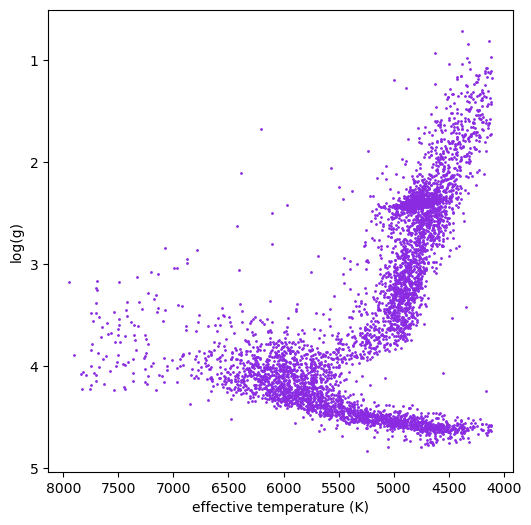

In [15]:
plt.figure(figsize=(6,6))
plt.scatter(galah_clean['teff'], galah_clean['logg'], s=1, c='blueviolet')
plt.gca().invert_xaxis() 
plt.gca().invert_yaxis()
plt.xlabel('effective temperature (K)')
plt.ylabel('log(g)')
plt.show()

You should have encountered most of these commands before, but the first line might be new: `plt.figure(figsize=(6,6))` tells `matplotlib` that the figure it creates should have a width of 6 and a height of 6. 

A `plt.figure()` command is not strictly necessary for making the plot, and `matplotlib` will still generate a figure if you don't include it! But if you want to control certain aspects of the figure (most frequently the size), you'll need to include this command. Here, we're using it to make sure that the outputted figure has a square aspect ratio, just to make it look a bit better.

### Exercise

Let's make another plot, this time showing the relationship between metallicity and barium (Ba) abundance.

First, filter the `galah_clean` table to only contain rows where `flag_fe_h` and `flag_Ba_fe` == 0. Store your trimmed table in a new variable. 

Then, generate a scatterplot from your new table, plotting [Fe/H] on the x-axis and [Ba/Fe] on the y-axis. Use `plt.axhline(1)` to add a horizontal line at y = 1. Stars that fall above this line are significantly "enriched" in Ba, meaning that the Ba content of their atmospheres is much higher than you would expect from their metallicity.

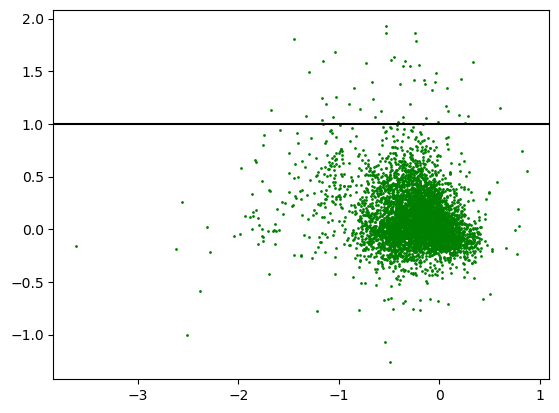

In [19]:
#Create trimmed dataset
fe_ba_subset = galah_clean[(galah_clean['flag_fe_h'] == 0) & (galah_clean['flag_Ba_fe'] == 0)]

#Generate figure
plt.scatter(fe_ba_subset['fe_h'], fe_ba_subset['Ba_fe'], s=1, color='green')
plt.axhline(1, color='black')
plt.show()

## Part 2: One-dimensional spectra

Now let’s explore the second type of data product that GALAH provides: 1D spectra for each star. In the actual GALAH data release, each star’s spectrum is split across multiple *chips* (detectors) and stored in FITS files.  For simplicity, I've retrieved an example spectrum and converted the data from one of the chips into a text file (`galah_1d_spec.txt`) that contains two columns, wavelength and flux.

### 2.1: Reading in and plotting the spectrum

To read this file, we'll use Python’s built-in `open()` function. When reading files with this function, you should always start by opening the file on your computer to get a sense of how the data is organized. For the provided file, each line contains just the wavelength and flux values separated by a single space. There are also two informational lines at the top, marked with the # symbol. We can read the file like this:

In [20]:
#Change this if needed!
path_to_1d_spec = 'galah_1d_spec.txt' 

In [23]:
wv, flux = [], [] #Create empty lists to store our wavelength and flux values in
with open(path_to_1d_spec, 'r') as file: #Open the file in read mode
    for line in file: #Iterate over each line of the file
        if line.startswith('#'): 
            continue #Skip lines that start with #
        split = line.split() #Divide up lines that aren't skipped
        wv.append(float(split[0])) #Add wavelength and flux values to your lists
        flux.append(float(split[1]))
        
wv = np.array(wv) #Convert lists to numpy arrays
flux = np.array(flux)

### Exercise

Use `plt.plot()` to visualize the spectrum. Plot wavelength on the x-axis and flux on the y-axis. You may also want to adjust the figure size.

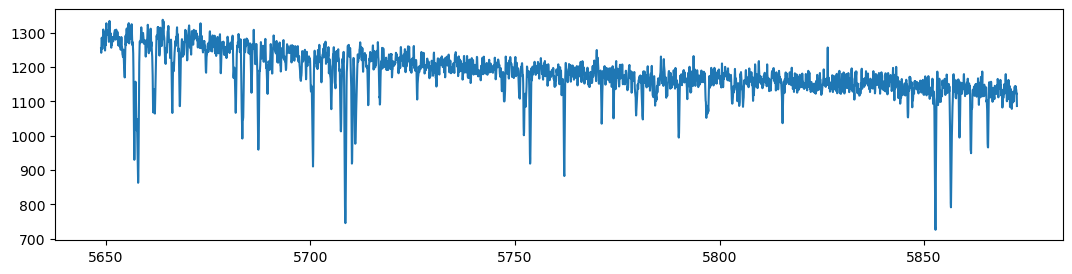

In [27]:
#Put your solution here!
plt.figure(figsize=(13, 3))
plt.plot(wv, flux)
plt.show()

### 2.3 Isolating a barium (Ba) line

We know there’s a Ba line at about 5853.6680 Å. Let’s zoom in on the region from 5851.67 Å to 5855.67 Å and plot a vertical line at the expected position of the Ba line (using `plt.axvline()`). Notice that the line isn't centered exactly on 5853.6680 Å. Why might this be the case?

In [28]:
Ba_line = 5853.6680
window = [5851.67, 5855.67]

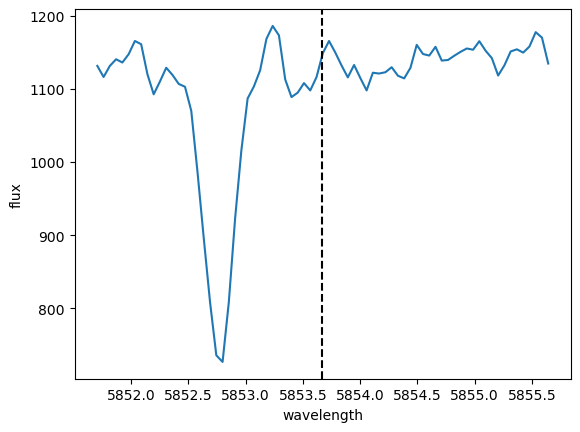

In [29]:
#Creating a mask that will select only points within the wavelength range specified
mask = (wv >= window[0]) & (wv <= window[1])

#Making a plot of the spectrum
plt.plot(wv[mask], flux[mask])
plt.axvline(Ba_line, color='black', linestyle='--')
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.show()

The answer is **radial velocity**. Most stars are either moving towards or away from us, causing their spectral lines to be Doppler shifted. We'll need to shift the star’s wavelength scale to rest frame to see the line exactly at its laboratory wavelength.

Luckily, the GALAH table includes a `rv_galah` column that reports the measured radial velocity of each star. If we know the star's RV, we can convert observed wavelengths into rest wavelengths as: 

$\lambda_{\mathrm{rest}} = \lambda_{\mathrm{obs}} \cdot \left(\frac{c}{c + v_{\mathrm{rad}}}\right)$

where $c$ is the speed of light in the same units as the radial velocity (km/s in GALAH).

### Exercise

Define a function called `rv_corr` that takes in two arguments: `wv_obs` (an array of observed wavelength values) and `rv` (a radial velocity). The function should apply the correction described above and return an array of rest-frame wavelength values. 

In [30]:
c = 299792.458 #km/s

#Write your function here
def rv_corr(wv_obs, rv):
    wv_rest = wv_obs * (c/(c+rv))
    return wv_rest

Now let's use your function to apply the wavelength correction to our data. The GALAH DR3 ID of our star is `131120001102089`. We can find the star's RV by selecting the row in our `galah_clean` table that corresponds to that ID, then accessing the `rv_galah` column:

In [31]:
rv = galah_clean[galah_clean['sobject_id'] == 131120001102089]['rv_galah']
print(f'RV: {rv[0]} km/s') #Without [0], an Astropy Table object is printed; we use it here just for nice formatting

RV: -48.62864342285157 km/s


We can now apply the correction and replot the data:

In [32]:
wv_corr = rv_corr(wv, rv)

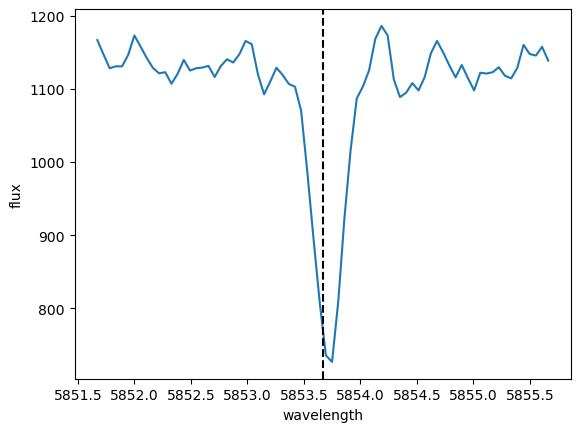

In [33]:
#Creating a mask that will select only points within the wavelength range specified
mask_corr = (wv_corr >= window[0]) & (wv_corr <= window[1])

#Making a plot of the spectrum
plt.plot(wv_corr[mask_corr], flux[mask_corr])
plt.axvline(Ba_line, color='black', linestyle='--')
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.show()

## Part 3: Introduction to `scipy.optimize.curve_fit`

In many areas of astronomy, fitting mathematical models to data is a crucial part of our analysis. The `curve_fit` function from SciPy’s `optimize` subpackage provides a powerful way to do this. Given a dataset and a user-defined model function (with as many parameters as you want!), `curve_fit` finds the best-fit parameters that minimize the difference between the model and the data. It uses nonlinear least squares fitting to iteratively adjust parameters until the model provides the best possible match. 

Let's explore the `curve_fit` function. We’ll start with a simple linear function, then show how to fit a Gaussian line to the spectral line that we just plotted.

In [34]:
#Importing the function
from scipy.optimize import curve_fit

### 3.1: Fitting a straight line

First, we'll generate some fake data that follows a linear trend of the form $y = mx + b$. There are two parameters in this model: $m$ (the slope) and $b$ (the intercept). To obscure these parameters, we'll add Gaussian random noise to perturb our fake data away from this line.

In [35]:
#Ensures reproducibility -- can be set to any number
np.random.seed(497) 

#Setting parameters
m_true = 2.0
b_true = 5.0

#Generating the fake data
x_data = np.linspace(0, 10, 50)
y_data = m_true * x_data + b_true + np.random.normal(0, 2.0, size=len(x_data))

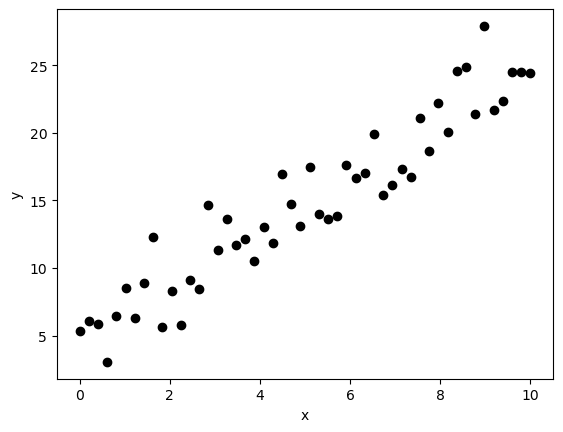

In [36]:
#Visualizing the data we just generated
plt.scatter(x_data, y_data, c='black')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

The first step of fitting a model to a dataset is deciding what model you want to use. Here, we already know that we want to fit a linear model. To use `curve_fit`, we then need to define a Python function that represent our model's general form. The function must meet the following requirements:

1. The first argument is the array of x-values to evaluate the function at
2. All free parameters are specified as additional arguments
3. The function evaluates the model at each of the inputted x-values and returns an array of corresponding y-values

For example, our linear model could be represented by a Python function `line_model(x, m, b)`. When provided with an array of values `x`, and a value for each of the two free parameters `m` and `b`, the function should return `y` where $y = mx + b$.

### Exercise
Implement the function `line_model(x, m, b)` as described above. 

In [37]:
#Put your solution here!
def line_model(x, m, b):
    y = m*x + b
    return y

In [ ]:
def pot(mass1, mass2):
    pot = MKPotential(a=a, b=b, amp=mass1) + second_potential
    

Once you've defined a function representing your model, you can use that function to plot different versions of the model. In the example below, we're plotting two different realizations of the model just by changing the values we're passing in for `m` and `b`.

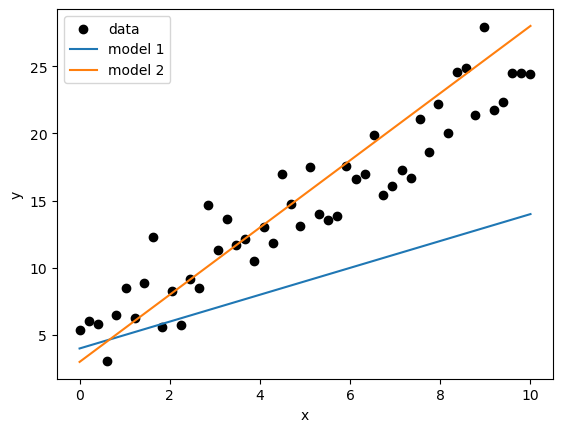

In [38]:
#Model 1
y_model1 = line_model(x_data, 1.0, 4.0)

#Model 2
y_model2 = line_model(x_data, 2.5, 3.0)

#Plotting the two models and the data together
plt.scatter(x_data, y_data, c='black', label='data')
plt.plot(x_data, y_model1, label='model 1')
plt.plot(x_data, y_model2, label='model 2')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In this case, we know that the best-fit parameters are $m = 2$ and $b = 5$. But in a real science case, these parameters would be unknown! We could try plotting a bunch of different models and picking the one that looks like the best match, but that approach isn't very scientific. To get a robust estimate of the best-fit parameters, we need to use something like `curve_fit`.

Below is a demonstration of how to fit the linear model to the fake data we generated using `curve_fit`. We pass in the function we wrote to describe our model (`line_model`) and our data (`x_data` and `y_data`). 

We also provide an initial guess for each parameter in the form of a list (`p0`). The order of the guesses in this list must match the order of the parameters in our function definition. Technically, this argument is optional, but you'll want to specify it most of the time to make sure that you get optimal results.

`curve_fit` will return two items:
1. `popt`: An array containing the best-fit parameters, in the same order they appear in our model function
2. `pcov`: The [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix) (from which we can derive uncertainties)

*Note: You can use any variable names you want, not just `popt` and `pcov`! This is just a convenient default syntax that is used in many online examples.*

In [39]:
popt, pcov = curve_fit(line_model, x_data, y_data, p0=[1.0, 1.0])

print(f'Best-fit parameters:\n{popt}\n')
print(f'Covariance matrix:\n{pcov}')

Best-fit parameters:
[2.00661882 4.71811267]

Covariance matrix:
[[ 0.00986443 -0.04932213]
 [-0.04932213  0.33216943]]


You'll see that these best-fit parameters are fairly close to the true values, but not perfect. This is to be expected given the level of noise we added to our dataset. Though we started from a line with certain parameters, there's no guarantee that line is still the best fit after adding noise.

Once we have the best fit parameters, we can plug them into our `line_model` function to get an array of best-fitting y-values. We can then plot the best-fitting model to see how it compares to our data:

In [40]:
m_fit, b_fit = popt[0], popt[1]
y_best = line_model(x_data, m_fit, b_fit)

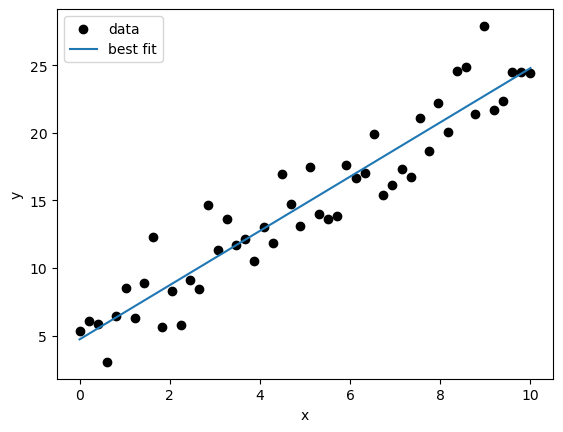

In [41]:
plt.scatter(x_data, y_data, c='black', label='data')
plt.plot(x_data, y_best, label='best fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Looks like a pretty close match! 

For simple models where the parameters are independent, you can get the error on the fitted parameters by taking the square root of the diagonal of the covariance matrix. (We won't discuss the underlying statistics, but you should read more about it if you're interested!)

In [42]:
m_err, b_err = np.sqrt(np.diag(pcov))
print(f"Best-fit parameters: m = {m_fit:.2f} ± {m_err:.2f}, b = {b_fit:.2f} ± {b_err:.2f}")

Best-fit parameters: m = 2.01 ± 0.10, b = 4.72 ± 0.58


`curve_fit` has several other optional parameters that can be used to modify its performance. One particularly useful parameter is `bounds`, which allows you to specify ranges that your best-fit parameters must fall within. For example, if you know that one of your models must be positive (because it represents something physical that can't be negative, like mass), you can specify bounds of `[0, np.inf]` to make sure `curve_fit` never considers negative numbers.

As always, you should check out the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) for more details!

### 3.2: Fitting a Gaussian to the GALAH spectrum

What if we wanted to fit a more complicated model? The beauty of `curve_fit` is that if you can write a function describing your model that meets these three criteria:

1. The first argument is the array of x-values to evaluate the function at
2. All free parameters are specified as additional arguments (as many as you want!)
3. The function evaluates the model at each of the inputted x-values and returns an array of corresponding y-values

then you can use `curve_fit` to find the best-fit parameters. Let's return to our GALAH spectrum and consider one such complicated case. 

Fitting a Gaussian distribution to a spectral line is a common way to measure line properties (like depth and [equivalent width](https://astronomy.swin.edu.au/cosmos/*/Equivalent+Width)). A generic Gaussian with mean $\mu$, standard deviation $\sigma$, amplitude $A$, and vertical offset $c$ can be described with the following function:

$y = A \exp\!\Big(-\frac{(x - \mu)^2}{2\sigma^2}\Big) + c$

Just like the linear model, we can implement this model as a function in Python:

In [43]:
def gaussian_model(wv, A, mu, sigma, c):
    return A * np.exp(-0.5 * ((wv - mu)/sigma)**2) + c

Now let's try fitting a Gaussian to our data. To make things easier, we'll define two new variables `g_wv` and `g_flux` that contain our corrected, trimmed wavelength and flux data from earlier. 

In [45]:
g_wv = wv_corr[mask_corr]
g_flux = flux[mask_corr]#/np.max(flux[mask_corr])

The next step would be defining an initial guess for our parameters. But what happens if we just try to run `curve_fit` straight out of the box?

In [46]:
popt_gauss, pcov_gauss = curve_fit(gaussian_model, g_wv, g_flux, p0=None)

/Applications/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [47]:
A_fit, mu_fit, sigma_fit, c_fit = popt_gauss
err_A, err_mu, err_sigma, err_c = np.sqrt(np.diag(pcov_gauss))

print("Best-fit parameters:")
print(f"A = {A_fit:.2f} ± {err_A:.2f}")
print(f"mu = {mu_fit:.4f} ± {err_mu:.4f}")
print(f"sigma = {sigma_fit:.4f} ± {err_sigma:.4f}")
print(f"c = {c_fit:.2f} ± {err_c:.2f}")

Best-fit parameters:
A = 1.00 ± inf
mu = 1.0000 ± inf
sigma = 1.0000 ± inf
c = 1100.95 ± inf


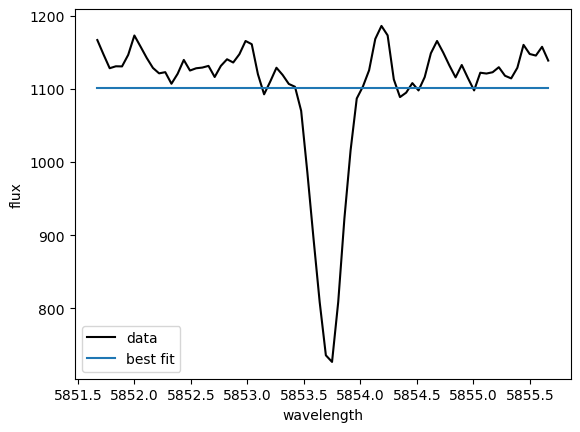

In [48]:
#Using the best-fit parameters to get the model flux values
flux_best_gauss = gaussian_model(g_wv, A_fit, mu_fit, sigma_fit, c_fit)

#Plotting the best fit in comparison to the data
plt.plot(g_wv, g_flux, c='black', label='data')
plt.plot(g_wv, flux_best_gauss, label='best fit')
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.legend()
plt.show()

That clearly didn't work. This is why it's so important to specify `p0` when using `curve_fit`. In most cases, the default values that `curve_fit` picks for your parameters will be quite far off from the actual values, and the function won't be able to converge on a reasonable solution. This can also happen if you provide bad guesses.

Usually, you'll be able to estimate a set of initial parameters just by thinking carefully about your data. For example, we know that the center of the line we're trying to fit is close to 5853 Å, so that might be a good initial pick for $\mu$. We also know that the amplitude of the Gaussian will need to be negative, since we're trying to fit an absorption line. 

Your initial picks don't have to be perfect, but getting them at least somewhat close will help `curve_fit` give you the best possible results!

### Exercise

When picking initial parameters, it can be helpful to plot an example realization of your model over your data, then play with the parameters until your model is a decent match. Think of what you might expect to be reasonable values for each of the parameters of our Gaussian model. Enter your guesses below and run the cell to plot a comparison between your guessed model and the data. Tweak your guessed parameters until the model seems like a somewhat reasonable match to the data.

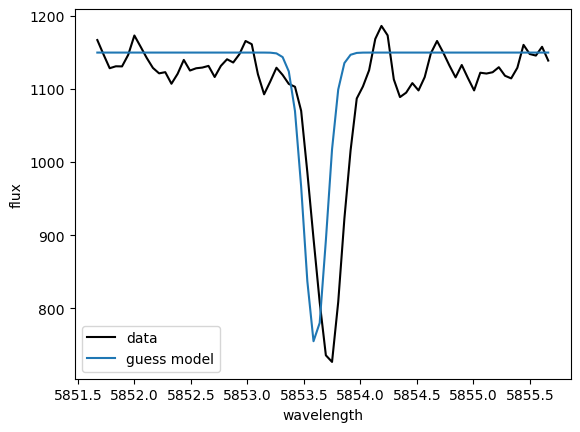

In [61]:
#ENTER YOUR GUESSES HERE
A_guess_2 = -400
mu_guess_2 = 5853.6
sigma_guess_2 = 0.1
c_guess_2 = 1150

# A_guess_2 = -2000.0   # negative amplitude for absorption, depends on flux scale
# mu_guess_2 = 5853.6   # near the known line center
# sigma_guess_2 = 0.1   # narrower line
# c_guess_2 = 1000.0   # approximate continuum


#Making a model with your guesses
flux_guess_2 = gaussian_model(g_wv, A_guess_2, mu_guess_2, sigma_guess_2, c_guess_2)

#Plotting the results
plt.plot(g_wv, g_flux, color='black', label='data')
plt.plot(g_wv, flux_guess_2, label='guess model')
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.legend()
plt.show()

Now let's try using `curve_fit` again, but with our improved initial guesses:

In [62]:
#Putting our guesses into a list (the format needed by curve_fit)
p0_gauss = [A_guess_2, mu_guess_2, sigma_guess_2, c_guess_2]

#Running curve_fit with our guesses
popt_gauss, pcov_gauss = curve_fit(gaussian_model, g_wv, g_flux, p0=p0_gauss)

In [63]:
#Retrieving and printing the best-fit parameters
A_fit, mu_fit, sigma_fit, c_fit = popt_gauss
err_A, err_mu, err_sigma, err_c = np.sqrt(np.diag(pcov_gauss))

print("Best-Fit Gaussian Parameters:")
print(f"A = {A_fit:.2f} ± {err_A:.2f}")
print(f"mu = {mu_fit:.4f} ± {err_mu:.4f}")
print(f"sigma = {sigma_fit:.4f} ± {err_sigma:.4f}")
print(f"c = {c_fit:.2f} ± {err_c:.2f}")

Best-Fit Gaussian Parameters:
A = -407.59 ± 12.50
mu = 5853.7159 ± 0.0044
sigma = 0.1255 ± 0.0045
c = 1132.65 ± 2.59


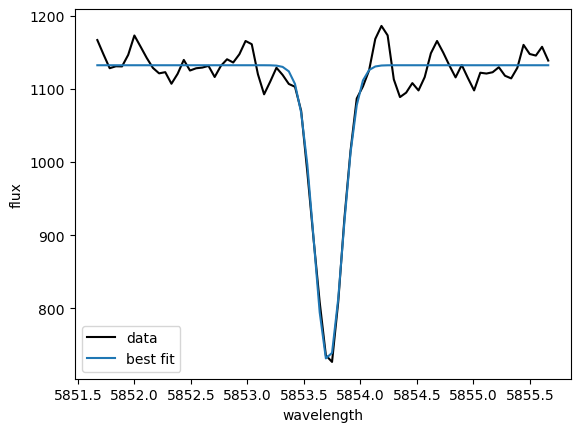

In [64]:
#Getting model flux values with the best-fit parameters
flux_best_gauss = gaussian_model(g_wv, A_fit, mu_fit, sigma_fit, c_fit)

#Visualizing the results
plt.plot(g_wv, g_flux, color='black', label='data')
plt.plot(g_wv, flux_best_gauss, label='best fit')
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.legend()
plt.show()

As expected, the match is much better!

In summary, when you want to fit a model (with an arbitrary shape and number of parameters) to a 2D dataset (with x and y values), `curve_fit` is a great option. Just make sure to follow these tips:

1. Write a function to represent your model that follows the format `curve_fit` expects
2. Test out different versions of your model by eye first so you can provide good initial guesses for your parameters
3. When in doubt, check the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) out!